# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

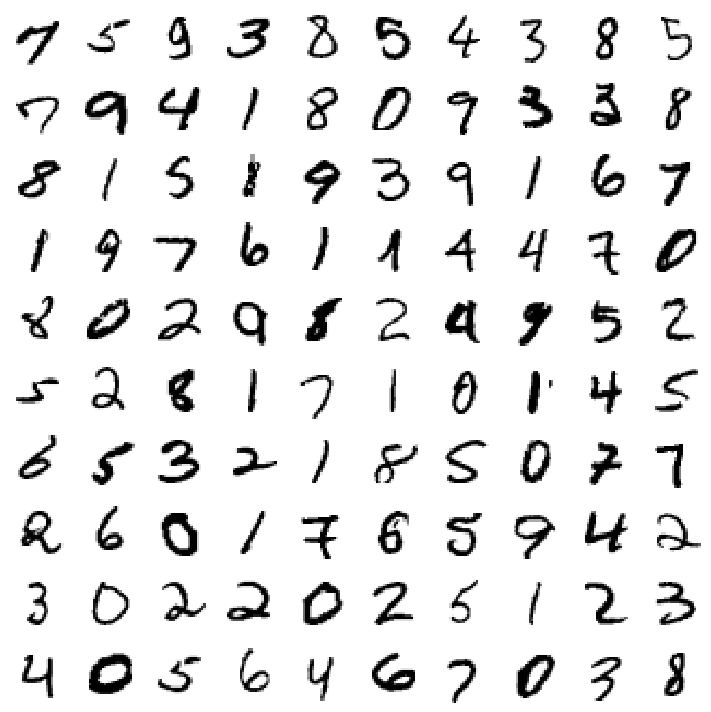

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
____

Compile and train the network (note that this could take a while).

In [3]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 13s 222us/sample - loss: 0.2306 - acc: 0.9300 - val_loss: 0.0512 - val_acc: 0.9840
Epoch 2/12
60000/60000 [==============================] - 12s 197us/sample - loss: 0.0869 - acc: 0.9747 - val_loss: 0.0378 - val_acc: 0.9875
Epoch 3/12
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0625 - acc: 0.9809 - val_loss: 0.0354 - val_acc: 0.9877
Epoch 4/12
60000/60000 [==============================] - 12s 198us/sample - loss: 0.0498 - acc: 0.9845 - val_loss: 0.0286 - val_acc: 0.9905
Epoch 5/12
60000/60000 [==============================] - 12s 197us/sample - loss: 0.0451 - acc: 0.9855 - val_loss: 0.0326 - val_acc: 0.9892
Epoch 6/12
60000/60000 [==============================] - 12s 197us/sample - loss: 0.0380 - acc: 0.9882 - val_loss: 0.0341 - val_acc: 0.9885
Epoch 7/12
60000/60000 [==============================] - 12s 195us/sample - loss: 0.0331 - acc: 0.9894 

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [4]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.028475804125366426
Test accuracy: 0.9923


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


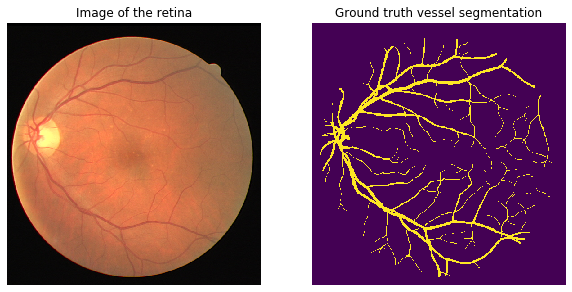

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [5]:
import sys
sys.path.append('code/')
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = 'C:/Users/20169037/Documents/BMT/Vakken/Jaar 4/Q1/Machine Learning in Medical Imaging and Biology/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


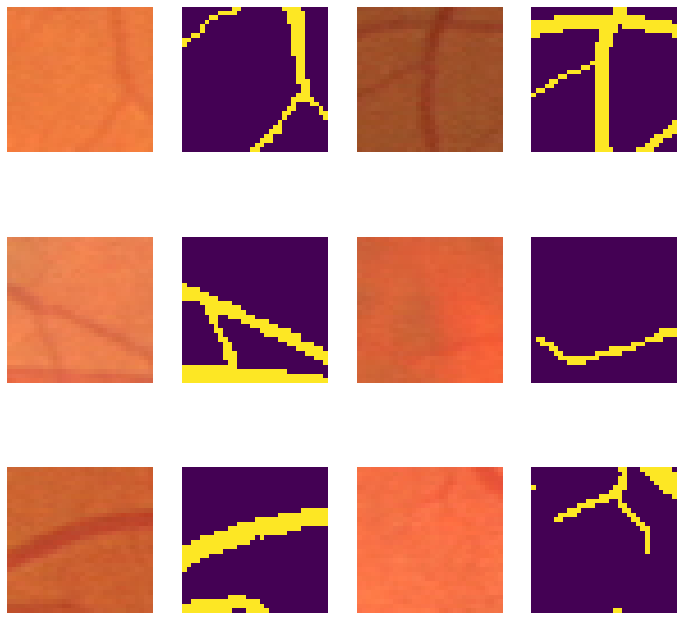

In [6]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [7]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [8]:
import os
from unet_model import unet
from unet_utils import datagenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/250
50/50 - 18s - loss: 0.5707 - acc: 0.7569 - val_loss: 0.4445 - val_acc: 0.9211
Epoch 2/250
50/50 - 6s - loss: 0.3031 - acc: 0.9481 - val_loss: 0.2892 - val_acc: 0.9211
Epoch 3/250
50/50 - 6s - loss: 0.2688 - acc: 0.9495 - val_loss: 0.2854 - val_acc: 0.9180
Epoch 4/250
50/50 - 6s - loss: 0.2239 - acc: 0.9521 - val_loss: 4.5203 - val_acc: 0.4570
Epoch 5/250
50/50 - 6s - loss: 0.1679 - acc: 0.9582 - val_loss: 0.2892 - val_acc: 0.9212
Epoch 6/250
50/50 - 6s - loss: 0.1450 - acc: 0.9595 - val_loss: 0.3044 - val_acc: 0.9215
Epoch 7/250
50/50 - 6s - loss: 0.1307 - acc: 0.9624 - val_loss: 0.2497 - val_acc: 0.9217
Epoch 8/250
50/50 - 6s - loss: 0.1350 - acc: 0.9610 - val_loss: 0.2537 - val_acc: 0.9272
Epoch 9/250
50/50 - 6s - loss: 0.1249 - acc: 0.9627 - val_loss: 0.2426 - val_acc: 0.9298
Epoch 10/250
50/50 - 6s - loss: 0.1164 - acc: 0.9635 - val_loss: 0.233

### Visualizing the segmentation results

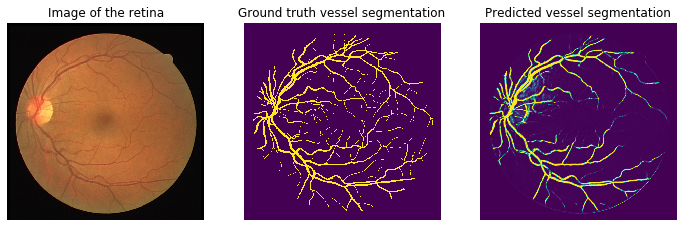

In [9]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>


ANSWER:

The parameters correspond to the weights of the connections and the batches.

Convolutional layer: (n\*m\*l+1)\*k with n the width of the filter, m the height of the filter, l the number of filters in the previous layer, +1 for the bias and k the number of filters in the current layer.

Fully-connected Layer: (n+1)\*m with n inputs and m outputs.




## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 




In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense 

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#model.add(Flatten())
model.add(Conv2D(128, (12, 12), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu',input_shape=(1,28,28), data_format='channels_first', padding='same'))


model.summary()


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 1, 1, 128)         1179776   
_________________________________________________________________
dropout_56 (Dropout)         (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 128, 1, 128)     

In [15]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 14s 229us/sample - loss: 0.2394 - acc: 0.9286 - val_loss: 0.0517 - val_acc: 0.9836
Epoch 2/12
60000/60000 [==============================] - 13s 212us/sample - loss: 0.0854 - acc: 0.9750 - val_loss: 0.0364 - val_acc: 0.9883
Epoch 3/12
60000/60000 [==============================] - 13s 217us/sample - loss: 0.0609 - acc: 0.9812 - val_loss: 0.0333 - val_acc: 0.9887
Epoch 4/12
60000/60000 [==============================] - 13s 222us/sample - loss: 0.0525 - acc: 0.9840 - val_loss: 0.0289 - val_acc: 0.9907
Epoch 5/12
60000/60000 [==============================] - 14s 228us/sample - loss: 0.0429 - acc: 0.9867 - val_loss: 0.0277 - val_acc: 0.9911
Epoch 6/12
60000/60000 [==============================] - 13s 219us/sample - loss: 0.0381 - acc: 0.9881 - val_loss: 0.0278 - val_acc: 0.9907
Epoch 7/12
60000/60000 [==============================] - 13s 223us/sample - loss: 0.0363 - acc: 0.9882 

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

ANSWER:

The skip connections in the U-Net architecture skips some layer in an Neural Network and subsequently feeds the output of one layer as the input to the next layers instead of just feeding it to the direct next layer (so it is used for multiple layers instead of just one). 

No, it will not be possible to train the exact same architecture with the skip connections omitted, at least not with the same results. It will result in possible vanishing gradient and hence give different results. This is because the whole idea of using skip connections is to preserve gradient information, created in the upper layers of the network, in the deeper layers of the network. Remove this technique and this information will be lost resulting in a different(ly trained) network.


## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

ANSWER:

Data augmentation increases the size of the data which increases the number of images present in the dataset. This reduces overfitting, because if we add more data, the model cannot overfit all samples and has to generalize more.

The augmentation of the data can technically be applied to the test samples as well. However, for the most accurate test results this will not always be the best option. Because augmenting the data could create some mistakes in the image and its correlation with the ground truth. In the train data set this will have a minor effect since it will still result in global aspects the model can train on and for the details the model can use the original data to finetune its prediction. However, the test data will reflect the model performance and the details are more important for the data in the test set. Hence it would not be advised to use augmented data in the test data set.



In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from numpy import expand_dims
from matplotlib import pyplot

def random_brightness(train_images=train_images):
    for j in train_images:
        data = img_to_array(j)
        samples = expand_dims(data,0)
        datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
        it = datagen.flow(samples, batch_size=1)
        for i in range(9):
            # define subplot
            pyplot.subplot(330 + 1 + i)
            # generate batch of images
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            # plot raw pixel data
            pyplot.imshow(image)
        # show the figure
        pyplot.show()
